# VAE and AE

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import structural_similarity as SSIM
from pathlib import Path
import matplotlib.pyplot as plt

## 1. Load data, create dataset and dataloader

In [2]:
eye_data = np.load('eye/data.npy') # (1476, 50, 50, 3)
eye_data = eye_data.transpose(0, 3, 1, 2) # (1476, 3, 50, 50)
eye_data = torch.Tensor(eye_data)

eye_label = np.load('eye/label.npy') # (1476, 1)
eye_label = torch.Tensor(eye_label)

In [3]:
BATCH = 18 
EPOCHS = 200
LATENT_DIM = 64 * 7 * 7# 512

In [4]:
class EyeDataset(Dataset):
    def __init__(self, data, label, transform=None):
        print("data shape: ", data.shape)
        print()
        self.data = data
        self.label = label
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.label[idx]
        if self.transform:
            data = self.transform(data)
        
        return data, label

In [5]:
eye_dataset = EyeDataset(data=eye_data, label=eye_label)
eye_dataloader = DataLoader(eye_dataset, batch_size=BATCH, shuffle=True)
eye_eval_dataloader = DataLoader(eye_dataset, batch_size=1, shuffle=False)

data shape:  torch.Size([1476, 3, 50, 50])



## 2. AE VAE weights construct and train

### 2.1 AE construct

In [6]:
# Define Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1), # output size is (N, 16, 25, 25)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1), # output size is (N, 32, 13, 13)
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), # output size is (N, 64, 7, 7)
            nn.ReLU(),
            
            nn.Flatten(),  # Flatten the output of the convolutional layers
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),  # Unflatten to 4D tensor
            
            nn.ConvTranspose2d(64, 32, 3, 2, 1), # output size is (N, 32, 13, 13)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, 2, 1), # output size is (N, 16, 25, 25)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, 2, 1, output_padding=1), # output size is (N, 3, 50, 50)
            nn.Sigmoid()
        )

    def forward(self, x, add_noise=False, noise=0.0):
        encoded = self.encoder(x)
        if add_noise:
            encoded = encoded + noise
        decoded = self.decoder(encoded)
        return decoded

### 2.2 AE Training

In [7]:
# Instantiate the Autoencoder
ae = Autoencoder()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

ae_train_loss_list = []
# AE Training loop
for epoch in range(EPOCHS):
    for batch_data, _ in eye_dataloader:
        optimizer.zero_grad()
        reconstructions = ae(batch_data)
        loss = criterion(reconstructions, batch_data)
        loss.backward()
        optimizer.step()
        
    ae_train_loss_list.append(loss.item())
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}")

Epoch [1/200], Loss: 0.0137
Epoch [10/200], Loss: 0.0033
Epoch [20/200], Loss: 0.0021
Epoch [30/200], Loss: 0.0022
Epoch [40/200], Loss: 0.0013
Epoch [50/200], Loss: 0.0012
Epoch [60/200], Loss: 0.0011
Epoch [70/200], Loss: 0.0012
Epoch [80/200], Loss: 0.0012
Epoch [90/200], Loss: 0.0015
Epoch [100/200], Loss: 0.0009
Epoch [110/200], Loss: 0.0009
Epoch [120/200], Loss: 0.0007
Epoch [130/200], Loss: 0.0008
Epoch [140/200], Loss: 0.0009
Epoch [150/200], Loss: 0.0009
Epoch [160/200], Loss: 0.0008
Epoch [170/200], Loss: 0.0006
Epoch [180/200], Loss: 0.0007
Epoch [190/200], Loss: 0.0008
Epoch [200/200], Loss: 0.0006


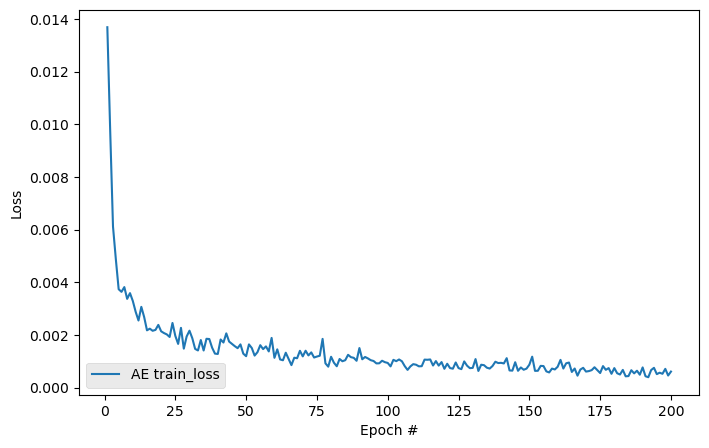

In [8]:
fig = plt.figure(figsize=(8, 5))
fig.add_subplot(2,2,(1,4))
plt.style.use("ggplot")

plt.plot(range(1, EPOCHS+1), ae_train_loss_list, label="AE train_loss")

plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

### 2.3 VAE Construct

In [9]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self):
        super(VariationalAutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1), # output size is (N, 16, 25, 25)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1), # output size is (N, 32, 13, 13)
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), # output size is (N, 64, 7, 7)
            nn.ReLU(),
            
            nn.Flatten(),  # Flatten the output of the convolutional layers
        )
        self.fc_mu = nn.Linear(64 * 7 * 7, LATENT_DIM)
        self.fc_logvar = nn.Linear(64 * 7 * 7, LATENT_DIM)
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),  # Unflatten to 4D tensor
            
            nn.ConvTranspose2d(64, 32, 3, 2, 1), # output size is (N, 32, 13, 13)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, 2, 1), # output size is (N, 16, 25, 25)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, 2, 1, output_padding=1), # output size is (N, 3, 50, 50)
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x, add_noise=False, noise=0.0):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        if add_noise:
            z = z +noise
        decoded = self.decoder(z)
        return decoded, mu, logvar

# Define loss function
def vae_loss(recons, originals, mu, logvar):
    recons_loss = F.mse_loss(recons, originals, reduction='sum')
    kl_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    return recons_loss, kl_loss, recons_loss + kl_loss

### 2.4 VAE Training

In [10]:
# Instantiate the VAE
vae = VariationalAutoEncoder()

optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
# VAE Training loop
vae_train_loss_list = []
recons_loss_list = []
kl_loss_list = []
for epoch in range(EPOCHS):
    for batch_data, _ in eye_dataloader:
        optimizer.zero_grad()
        reconstructions, mu, logvar = vae(batch_data)
        recons_loss, kl_loss, loss = vae_loss(reconstructions, batch_data, mu, logvar)
        loss.backward()
        optimizer.step()
    vae_train_loss_list.append(loss.item())
    recons_loss_list.append(recons_loss.item())
    kl_loss_list.append(kl_loss.item())
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Recons: {recons_loss.item():.4f}, KL: {kl_loss.item():.4f}")

Epoch [1/200], Loss: 2323.7344, Recons: 1990.6161, KL: 333.1183
Epoch [10/200], Loss: 1148.1803, Recons: 818.8788, KL: 329.3015
Epoch [20/200], Loss: 782.0024, Recons: 542.9108, KL: 239.0916
Epoch [30/200], Loss: 666.0635, Recons: 423.7643, KL: 242.2993
Epoch [40/200], Loss: 725.9061, Recons: 467.3898, KL: 258.5163
Epoch [50/200], Loss: 687.9739, Recons: 434.8638, KL: 253.1101
Epoch [60/200], Loss: 773.4026, Recons: 460.9507, KL: 312.4519
Epoch [70/200], Loss: 666.6902, Recons: 383.9193, KL: 282.7709
Epoch [80/200], Loss: 793.4194, Recons: 484.8830, KL: 308.5365
Epoch [90/200], Loss: 657.0737, Recons: 390.2876, KL: 266.7861
Epoch [100/200], Loss: 731.9604, Recons: 442.3668, KL: 289.5937
Epoch [110/200], Loss: 690.5684, Recons: 412.5256, KL: 278.0428
Epoch [120/200], Loss: 673.1131, Recons: 383.3361, KL: 289.7770
Epoch [130/200], Loss: 690.7698, Recons: 407.7414, KL: 283.0284
Epoch [140/200], Loss: 647.3157, Recons: 365.9746, KL: 281.3410
Epoch [150/200], Loss: 684.8934, Recons: 397.143

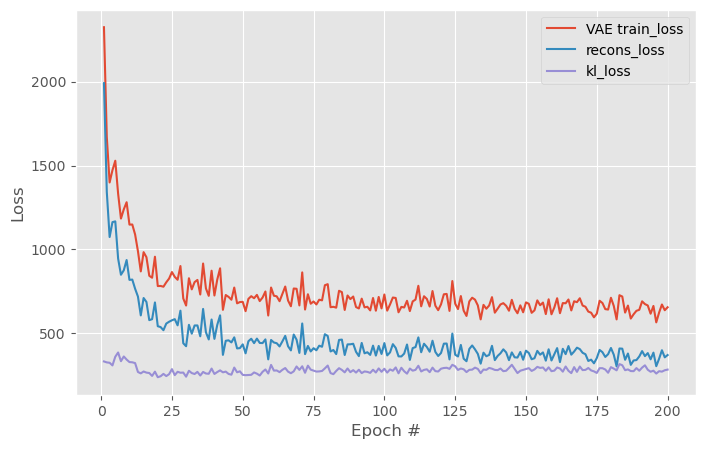

In [11]:
fig = plt.figure(figsize=(8, 5))
fig.add_subplot(2,2,(1,4))
plt.style.use("ggplot")

plt.plot(range(1, EPOCHS+1), vae_train_loss_list, label="VAE train_loss")
plt.plot(range(1, EPOCHS+1), recons_loss_list, label="recons_loss")
plt.plot(range(1, EPOCHS+1), kl_loss_list, label="kl_loss")

plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

plt.show()

## 3. Save AE VAE model, evaluate and show picture

In [28]:
Path("results/origin/vae_result/").mkdir(parents=True, exist_ok=True)
Path("results/origin/ae_result/").mkdir(parents=True, exist_ok=True)
Path("results/origin/GT/").mkdir(parents=True, exist_ok=True)
Path("weights").mkdir(parents=True, exist_ok=True)

In [13]:
vae_file_path = 'weights/VAE.pt'
torch.save(vae, vae_file_path)
ae_file_path = 'weights/AE.pt'
torch.save(ae, ae_file_path)

ae PSNR:33.63671508028526, SSIM:0.9568868279457092
vae PSNR:25.947074247774566, SSIM:0.783991277217865


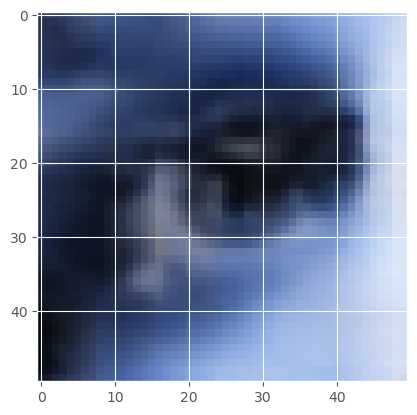

In [29]:
ae_recons_result_list = []
ae_PSNR_list = []
ae_SSIM_list = []
vae_recons_result_list = []
vae_PSNR_list = []
vae_SSIM_list = []


ae_model = torch.load(ae_file_path)
vae_model = torch.load(vae_file_path)
ae_model.eval()
vae_model.eval() 

# for batch_data, _ in eye_eval_dataloader:
for i, (batch_data, _) in enumerate(eye_eval_dataloader):
    with torch.no_grad():
        optimizer.zero_grad()
        ae_reconstructions = ae(batch_data)
        vae_reconstructions, _, _ = vae(batch_data)
        
        vae_recon_img = torch.squeeze(vae_reconstructions).permute(1, 2, 0).numpy()
        ae_recon_img = torch.squeeze(ae_reconstructions).permute(1, 2, 0).numpy()
        batch_img = torch.squeeze(batch_data).permute(1, 2, 0).numpy()
        if i+1 in [91, 92, 93, 94, 95, 481, 482, 483, 484, 485, 936, 937, 938, 939, 940, 1446, 1447, 1448, 1449, 1450]:
            plt.imshow(batch_img)
            plt.savefig(f'results/origin/GT/{i+1}.png')
            plt.imshow(ae_recon_img)
            plt.savefig(f'results/origin/ae_result/{i+1}.png')
            plt.imshow(vae_recon_img)
            plt.savefig(f'results/origin/vae_result/{i+1}.png')
            


        ae_psnr_result = PSNR(ae_recon_img, batch_img)
        ae_ssim_result = SSIM(ae_recon_img, batch_img, multichannel=True, data_range=ae_recon_img.max() - ae_recon_img.min(),channel_axis=2)
        ae_PSNR_list.append(ae_psnr_result)   
        ae_SSIM_list.append(ae_ssim_result)
        
        vae_psnr_result = PSNR(vae_recon_img, batch_img)
        vae_ssim_result = SSIM(vae_recon_img, batch_img, multichannel=True, data_range=vae_recon_img.max() - vae_recon_img.min(),channel_axis=2)
        vae_PSNR_list.append(vae_psnr_result)   
        vae_SSIM_list.append(vae_ssim_result)

print(f'ae PSNR:{np.mean(ae_PSNR_list)}, SSIM:{np.mean(ae_SSIM_list)}')
print(f'vae PSNR:{np.mean(vae_PSNR_list)}, SSIM:{np.mean(vae_SSIM_list)}')

## 4. Skip connection Version

In [15]:
class SkipConnectionVAE(nn.Module):
    def __init__(self):
        super(SkipConnectionVAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1), # output size is (N, 16, 25, 25)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1), # output size is (N, 32, 13, 13)
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), # output size is (N, 64, 7, 7)
            nn.ReLU(),
            
            nn.Flatten(),  # Flatten the output of the convolutional layers
        )
        self.fc_mu = nn.Linear(64 * 7 * 7, LATENT_DIM)
        self.fc_logvar = nn.Linear(64 * 7 * 7, LATENT_DIM)
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),  # Unflatten to 4D tensor (N, 64, 7, 7)
            
            nn.ConvTranspose2d(64, 32, 3, 2, 1), # output size is (N, 32, 13, 13)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, 2, 1), # output size is (N, 16, 25, 25)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, 2, 1, output_padding=1), # output size is (N, 3, 50, 50)
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x, add_noise=False, noise=0.0):
        encode_list = []
        for idx, layer in enumerate(self.encoder):
            x = layer(x)
            if idx in [0, 2, 4]:
                encode_list.append(x)
    
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        x = self.reparameterize(mu, logvar)
        
        if add_noise:
            x = x + noise
        for idx, layer in enumerate(self.decoder):
            x = layer(x)
            if idx in [0, 1, 3]:
                x = x + encode_list.pop() # Add with skip connection
        
        return x, mu, logvar


# Define loss function
def skvae_loss(recons, originals, mu, logvar):
    recons_loss = F.mse_loss(recons, originals, reduction='sum')
    kl_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    return recons_loss, kl_loss, recons_loss + kl_loss

In [16]:
# Instantiate the SkVAE
skvae = SkipConnectionVAE()
sk_optimizer = torch.optim.Adam(skvae.parameters(), lr=0.001)

# Skip Connection VAE Training loop
skvae_train_loss_list = []
sk_recons_loss_list = []
sk_kl_loss_list = []
for epoch in range(EPOCHS):
    for batch_data, _ in eye_dataloader:
        sk_optimizer.zero_grad()
        reconstructions, mu, logvar = skvae(batch_data)
        sk_recons_loss, sk_kl_loss, sk_loss = skvae_loss(reconstructions, batch_data, mu, logvar)
        sk_loss.backward()
        sk_optimizer.step()
    
    skvae_train_loss_list.append(sk_loss.item())
    sk_recons_loss_list.append(sk_recons_loss.item())
    sk_kl_loss_list.append(sk_kl_loss.item())
    
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"skvae Epoch [{epoch+1}/{EPOCHS}], Loss: {sk_loss.item():.4f}, Recons: {sk_recons_loss.item():.4f}, KL: {sk_kl_loss.item():.4f}")

skvae Epoch [1/200], Loss: 1242.0526, Recons: 1181.5337, KL: 60.5189
skvae Epoch [10/200], Loss: 271.6837, Recons: 264.7294, KL: 6.9543
skvae Epoch [20/200], Loss: 177.7112, Recons: 175.9017, KL: 1.8094
skvae Epoch [30/200], Loss: 140.8701, Recons: 139.6279, KL: 1.2422
skvae Epoch [40/200], Loss: 105.8497, Recons: 105.2644, KL: 0.5853
skvae Epoch [50/200], Loss: 103.7809, Recons: 103.3685, KL: 0.4124
skvae Epoch [60/200], Loss: 54.6953, Recons: 54.5133, KL: 0.1820
skvae Epoch [70/200], Loss: 70.5243, Recons: 70.3294, KL: 0.1950
skvae Epoch [80/200], Loss: 74.2843, Recons: 73.6663, KL: 0.6180
skvae Epoch [90/200], Loss: 51.6919, Recons: 51.4912, KL: 0.2007
skvae Epoch [100/200], Loss: 51.1742, Recons: 51.0057, KL: 0.1684
skvae Epoch [110/200], Loss: 37.6953, Recons: 37.6185, KL: 0.0767
skvae Epoch [120/200], Loss: 41.2838, Recons: 41.0251, KL: 0.2587
skvae Epoch [130/200], Loss: 30.8346, Recons: 30.6893, KL: 0.1453
skvae Epoch [140/200], Loss: 37.1624, Recons: 37.0147, KL: 0.1476
skvae 

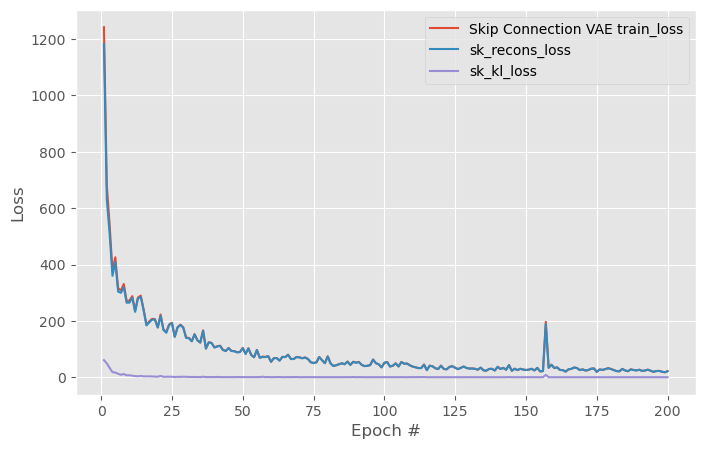

In [17]:
fig = plt.figure(figsize=(8, 5))
fig.add_subplot(2,2,(1,4))
plt.style.use("ggplot")

plt.plot(range(1, EPOCHS+1), skvae_train_loss_list, label="Skip Connection VAE train_loss")
plt.plot(range(1, EPOCHS+1), sk_recons_loss_list, label="sk_recons_loss")
plt.plot(range(1, EPOCHS+1), sk_kl_loss_list, label="sk_kl_loss")

plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

plt.show()

## 5. Deeper Version

In [18]:
class DeeperVAE(nn.Module):
    def __init__(self):
        super(DeeperVAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1), # output size is (N, 16, 25, 25)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1), # output size is (N, 32, 13, 13)
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), # output size is (N, 64, 7, 7)
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1), # output size is (N, 128, 4, 4)
            nn.ReLU(),
            nn.Flatten(),  # Flatten the output of the convolutional layers
        )
        self.fc_mu = nn.Linear(128 * 4 * 4, 128 * 4 * 4)
        self.fc_logvar = nn.Linear(128 * 4 * 4, 128 * 4 * 4)
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 4, 4)),  # Unflatten to 4D tensor (N, 128, 4, 4)
            nn.ConvTranspose2d(128, 64, 3, 2, 1), # output size is (N, 64, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, 2, 1), # output size is (N, 32, 13, 13)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, 2, 1), # output size is (N, 16, 25, 25)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, 2, 1, output_padding=1), # output size is (N, 3, 50, 50)
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x, add_noise=False, noise=0.0):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        if add_noise:
            z = z +noise
        decoded = self.decoder(z)
        return decoded, mu, logvar

# Define loss function
def dpvae_loss(recons, originals, mu, logvar):
    recons_loss = F.mse_loss(recons, originals, reduction='sum')
    kl_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    return recons_loss, kl_loss, recons_loss + kl_loss

In [19]:
# Instantiate the DpVAE
dpvae = DeeperVAE()

dp_optimizer = torch.optim.Adam(dpvae.parameters(), lr=0.001)

# Deeper VAE Training loop
dpvae_train_loss_list = []
dp_recons_loss_list = []
dp_kl_loss_list = []
for epoch in range(EPOCHS):
    for batch_data, _ in eye_dataloader:
        dp_optimizer.zero_grad()
        reconstructions, mu, logvar = dpvae(batch_data)
        dp_recons_loss, dp_kl_loss, dp_loss = dpvae_loss(reconstructions, batch_data, mu, logvar)
        dp_loss.backward()
        dp_optimizer.step()
    dpvae_train_loss_list.append(dp_loss.item())
    dp_recons_loss_list.append(dp_recons_loss.item())
    dp_kl_loss_list.append(dp_kl_loss.item())
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {dp_loss.item():.4f}, Recons: {dp_recons_loss.item():.4f}, KL: {dp_kl_loss.item():.4f}")

Epoch [1/200], Loss: 5419.7148, Recons: 5330.3179, KL: 89.3969
Epoch [10/200], Loss: 1242.0078, Recons: 998.8074, KL: 243.2005
Epoch [20/200], Loss: 909.0159, Recons: 688.9349, KL: 220.0810
Epoch [30/200], Loss: 923.8312, Recons: 734.3841, KL: 189.4471
Epoch [40/200], Loss: 782.7083, Recons: 584.9199, KL: 197.7884
Epoch [50/200], Loss: 726.0970, Recons: 540.1097, KL: 185.9873
Epoch [60/200], Loss: 698.8464, Recons: 509.2897, KL: 189.5566
Epoch [70/200], Loss: 799.3354, Recons: 577.2462, KL: 222.0893
Epoch [80/200], Loss: 704.6273, Recons: 508.8077, KL: 195.8196
Epoch [90/200], Loss: 662.4113, Recons: 464.3819, KL: 198.0294
Epoch [100/200], Loss: 670.3014, Recons: 473.5760, KL: 196.7254
Epoch [110/200], Loss: 627.2831, Recons: 448.6193, KL: 178.6638
Epoch [120/200], Loss: 710.6002, Recons: 525.7723, KL: 184.8280
Epoch [130/200], Loss: 591.3840, Recons: 404.1526, KL: 187.2314
Epoch [140/200], Loss: 637.4857, Recons: 444.8087, KL: 192.6770
Epoch [150/200], Loss: 597.0702, Recons: 402.3652

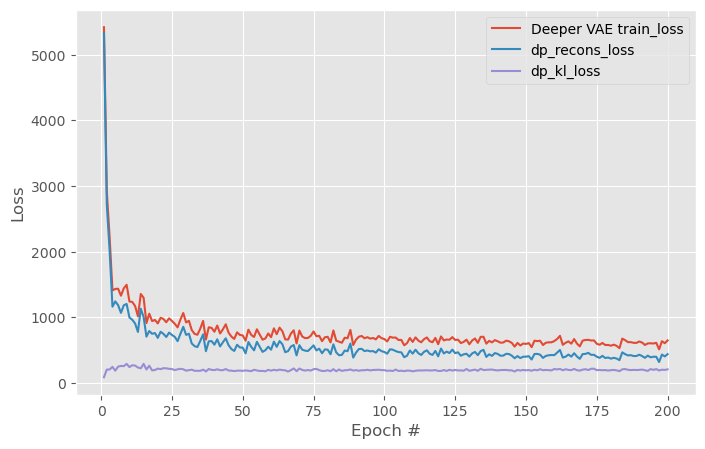

In [20]:
fig = plt.figure(figsize=(8, 5))
fig.add_subplot(2,2,(1,4))
plt.style.use("ggplot")

plt.plot(range(1, EPOCHS+1), dpvae_train_loss_list, label="Deeper VAE train_loss")
plt.plot(range(1, EPOCHS+1), dp_recons_loss_list, label="dp_recons_loss")
plt.plot(range(1, EPOCHS+1), dp_kl_loss_list, label="dp_kl_loss")

plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

plt.show()

## 6. Save Deeper and Skip connection version model

In [21]:
Path("results/origin/skvae_result/").mkdir(parents=True, exist_ok=True)
Path("results/origin/dpvae_result/").mkdir(parents=True, exist_ok=True)
skvae_file_path = 'weights/SK.pt'
dpvae_file_path = 'weights/DP.pt'
torch.save(skvae, skvae_file_path)
torch.save(dpvae, dpvae_file_path)

skvae PSNR:38.239886342749685, SSIM:0.9843150973320007
dpvae PSNR:25.45824810000497, SSIM:0.758801281452179


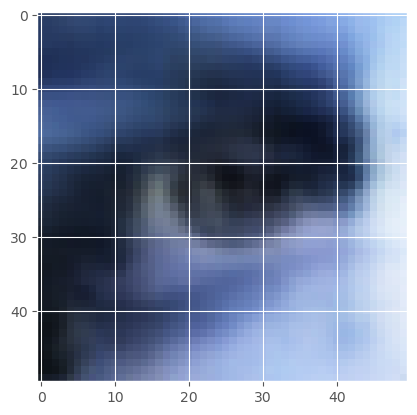

In [22]:
skvae_recons_result_list = []
skvae_PSNR_list = []
skvae_SSIM_list = []
dpvae_recons_result_list = []
dpvae_PSNR_list = []
dpvae_SSIM_list = []

skvae_model = torch.load(skvae_file_path)
dpvae_model = torch.load(dpvae_file_path)
skvae_model.eval()
dpvae_model.eval() 

for i, (batch_data, _) in enumerate(eye_eval_dataloader):
    with torch.no_grad():
        sk_optimizer.zero_grad()
        dp_optimizer.zero_grad()
        skvae_reconstructions, _, _ = skvae(batch_data)
        dpvae_reconstructions, _, _ = dpvae(batch_data)
        
        skvae_recon_img = torch.squeeze(skvae_reconstructions).permute(1, 2, 0).numpy()
        dpvae_recon_img = torch.squeeze(dpvae_reconstructions).permute(1, 2, 0).numpy()
        batch_img = torch.squeeze(batch_data).permute(1, 2, 0).numpy()
        if i+1 in [91, 92, 93, 94, 95, 481, 482, 483, 484, 485, 936, 937, 938, 939, 940, 1446, 1447, 1448, 1449, 1450]:
            plt.imshow(skvae_recon_img)
            plt.savefig(f'results/origin/skvae_result/{i+1}.png')
            plt.imshow(dpvae_recon_img)
            plt.savefig(f'results/origin/dpvae_result/{i+1}.png')


        skvae_psnr_result = PSNR(skvae_recon_img, batch_img)
        skvae_ssim_result = SSIM(skvae_recon_img, batch_img, multichannel=True, data_range=skvae_recon_img.max() - skvae_recon_img.min(),channel_axis=2)
        skvae_PSNR_list.append(skvae_psnr_result)   
        skvae_SSIM_list.append(skvae_ssim_result)
        
        dpvae_psnr_result = PSNR(dpvae_recon_img, batch_img)
        dpvae_ssim_result = SSIM(dpvae_recon_img, batch_img, multichannel=True, data_range=dpvae_recon_img.max() - dpvae_recon_img.min(),channel_axis=2)
        dpvae_PSNR_list.append(dpvae_psnr_result)   
        dpvae_SSIM_list.append(dpvae_ssim_result)

print(f'skvae PSNR:{np.mean(skvae_PSNR_list)}, SSIM:{np.mean(skvae_SSIM_list)}')
print(f'dpvae PSNR:{np.mean(dpvae_PSNR_list)}, SSIM:{np.mean(dpvae_SSIM_list)}')

## 7. Evaluate with Gaussian Noise

In [26]:
Path("results/noise/noise_ae_result/").mkdir(parents=True, exist_ok=True)
Path("results/noise/noise_vae_result/").mkdir(parents=True, exist_ok=True)
Path("results/noise/noise_skvae_result/").mkdir(parents=True, exist_ok=True)
ae_file_path = 'weights/AE.pt'
vae_file_path = 'weights/VAE.pt'
skvae_file_path = 'weights/SK.pt'

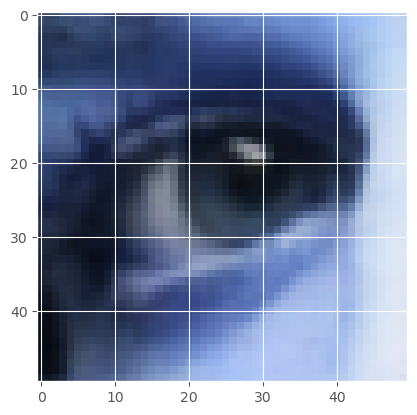

In [27]:
ae_model = torch.load(ae_file_path)
vae_model = torch.load(vae_file_path)
skvae_model = torch.load(skvae_file_path)
ae_model.eval()
vae_model.eval()
skvae_model.eval()

for i, (batch_data, _) in enumerate(eye_eval_dataloader):
    with torch.no_grad():
        optimizer.zero_grad()
        Gaussian_noise = torch.randn(LATENT_DIM)
        ae_reconstructions = ae(batch_data, add_noise=True, noise=Gaussian_noise)
        vae_reconstructions, _, _ = vae(batch_data, add_noise=True, noise=Gaussian_noise)
        skvae_reconstructions, _, _ = skvae(batch_data, add_noise=True, noise=Gaussian_noise)
        
        vae_recon_img = torch.squeeze(vae_reconstructions).permute(1, 2, 0).numpy()
        ae_recon_img = torch.squeeze(ae_reconstructions).permute(1, 2, 0).numpy()
        skvae_recon_img = torch.squeeze(skvae_reconstructions).permute(1, 2, 0).numpy()
        batch_img = torch.squeeze(batch_data).permute(1, 2, 0).numpy()
        if i+1 in [91, 92, 93, 94, 95, 481, 482, 483, 484, 485, 936, 937, 938, 939, 940, 1446, 1447, 1448, 1449, 1450]:
            plt.imshow(ae_recon_img)
            plt.savefig(f'results/noise/noise_ae_result/{i+1}.png')
            plt.imshow(vae_recon_img)
            plt.savefig(f'results/noise/noise_vae_result/{i+1}.png')
            plt.imshow(skvae_recon_img)
            plt.savefig(f'results/noise/noise_skvae_result/{i+1}.png')
